# Junction 

This notebook shows how to build a cross junction. 

In [17]:
import ipyparallel as ipp

# Start the cluster with 4 engines
cluster = ipp.Cluster(n=4)
cluster.start_and_connect()

<coroutine object Cluster.start_and_connect at 0x7f1b6426d360>

**Import zone**

In [18]:
# Import needed packages
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

import numpy as np
import scipy.constants as ct

# Import some classes and functions from the 'electrode' package
from electrode import (System, PolygonPixelElectrode, shaped)

# Import function for shims calculations
from shims import calc_shims 

# set numpy precision to 4 decimals
np.set_printoptions(precision=4)

# Python magic needed for matplotlib
%matplotlib inline

# Choose matplotlib options
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['axes.unicode_minus'] = False
rcParams.update({
    "font.size": 14,             # base font size
    "axes.labelsize": 15,        # x/y labels
    "axes.titlesize": 15,        # title
    "xtick.labelsize": 12,       # tick labels
    "ytick.labelsize": 12,
    "legend.fontsize": 12,       # legend
    "axes.linewidth": 1.2,
    "lines.linewidth": 1.5,      # thicker default lines
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

**Plotting functions**

In [19]:
def plot_trap_geometry(s, xmax=3500, ymax=3500):
    fig, ax = plt.subplots(3, 1, figsize=(7, 15))
  
    # Plot trap geometry
    s.plot(ax[0])
  
    # Plot RF and DC voltages
    s.plot_voltages(ax[1], u=s.rfs)
    s.plot_voltages(ax[2], u=s.dcs)
  
    # Compute voltage range
    vmin = np.min([np.min(s.rfs), np.min(s.dcs)])
    vmax = np.max([np.max(s.rfs), np.max(s.dcs)])
  
    # Colormap normalization
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
  
    # Add colorbars for RF and DC voltages
    cb1 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], shrink=0.9, aspect=35)
    cb1.ax.tick_params(labelsize=10)
    cb1.set_label('Voltage', fontsize=10)
  
    cb2 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[2], shrink=0.9, aspect=35)
    cb2.ax.tick_params(labelsize=10)
    cb2.set_label('Voltage', fontsize=10)
  
    # Set titles
    ax[0].set_title("Trap Geometry")
    ax[1].set_title("RF Voltages")
    ax[2].set_title("DC Voltages")
  
    # Set plot limits and properties
    for axi in ax.flat:
        axi.set_aspect("equal")
        axi.set_xlim(-xmax, xmax)
        axi.set_ylim(-ymax, ymax)
        axi.set_xlabel('x (μm)')
        axi.set_ylabel('y (μm)')
  
    plt.tight_layout()
    plt.show()

In [20]:
def plot_potential_sections(s, x_cut, y_cut, z_cut, x0, xss, xmin, xmax, ymin, ymax, zmin, zmax, n, v_min, v_max, v, p_tot0): 
    fig = plt.figure(figsize=(15, 8))
    
    # (1) x-y cross section
    ax0 = plt.subplot2grid((2,2), (0,0))
    ax0.set_title("x-y cross section at minimum z = {0:.3g} um".format(z_cut))
    ax0.set_xlabel('x (um)')
    ax0.set_ylabel('y (um)')
    
    # Build grid (z kept constant) and compute potential on the 2D plane
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+.1]
    pot = shaped(s.potential)(xyz)
    
    # Reshape data as 2D arrays for contour plot
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    
    # Plot contour lines
    CS = ax0.contour(x, y, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
    
    # Build heatmap of potential (wrt to the potential in x0 set to 0).
    im = ax0.imshow((p-p_tot0).T, origin='lower', vmin=v_min, vmax=v_max, 
                    extent=(xmin, xmax, ymin, ymax))
    ax0.scatter(x0[0], x0[1], color='cyan', marker='o', s=10) # Plot minimum
    for xs in xss:
        ax0.scatter(xs[0], xs[1], color='cyan', marker='o', s=10) # Plot saddle point
    im.set_interpolation('bilinear') # For avoiding pixelation
    cb = fig.colorbar(im, ax=ax0, shrink=0.8) # Adding colorbar
    
    
    # (2) x-z cross section
    ax1 = plt.subplot2grid((2,2), (1,0))
    ax1.set_title("x-z cross section at minimum y={0:.3g}um".format(y_cut))
    ax1.set_xlabel('x (um)')
    ax1.set_ylabel('z (um)')
    
    # Now y is kept constant
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+.1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n,n) for _ in (xyz[0], xyz[2], pot))
    CS = ax1.contour(x, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
    im = ax1.imshow((p-p_tot0).T, origin='lower', vmin=v_min, vmax=v_max, 
                    extent=(xmin,xmax,zmin,zmax))
    ax1.scatter(x0[0], x0[2], color='cyan', marker='o', s=10)
    for xs in xss:
        ax1.scatter(xs[0], xs[2], color='cyan', marker='o', s=10)
    im.set_interpolation('bilinear')
    cb = fig.colorbar(im, ax=ax1, shrink=0.8)
    
    
    # y-z cross section (uses two rows)
    ax2 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax2.set_title("y-z cross section at minimum x={0:.3g}um".format(x_cut))
    ax2.set_xlabel('y (um)')
    ax2.set_ylabel('z (um)')
    
    # Here x is kept constant
    xyz = np.mgrid[x_cut:x_cut+.1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    y, z, p = (_.reshape(n,n) for _ in (xyz[1], xyz[2], pot))
    CS = ax2.contour(y, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
    im = ax2.imshow((p-p_tot0).T, origin='lower', vmin=v_min, vmax=v_max, 
                    extent=(ymin,ymax,zmin,zmax))
    ax2.scatter(x0[1], x0[2], color='cyan', marker='o', s=10)
    for xs in xss:
        ax2.scatter(xs[1], xs[2], color='cyan', marker='o', s=10)
    im.set_interpolation('bilinear')
    cb = fig.colorbar(im, ax=ax2, shrink=0.8)

In [21]:
def plot_ps(x_values, pseudopot_values, positions, omega_sec):
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))  # 4 subplots stacked vertically
    ax = ax.flatten()  # now ax[0], ax[1], ax[2], ax[3] work
  
    # First subplot: Pseudo-potential and its gradient
    ax[0].plot(x_values, np.array(pseudopot_values) / 1e-3, label="Pseudo-potential")
    gradient_values = np.gradient(np.array(pseudopot_values) / 1e-3, x_values)
    ax[0].plot(x_values, gradient_values * 10, linestyle='--', label=f'Gradient (magnified * 10) meV/μm\nIntegral = {np.sum(np.absolute(gradient_values)):.3f}')
    ax[0].set_ylabel("Pseudo-potential (meV)")
    ax[0].set_title("Pseudo-potential along x")
    ax[0].grid(True, linestyle="--", alpha=0.6)
    ax[0].legend(loc='upper left')
  
    # Second subplot: Position components
#    ax[2].plot(x_values, np.array(positions)[:, 0], label='X Position')
#    ax[2].plot(x_values, np.array(positions)[:, 1], label='Y Position')
    ax[2].plot(x_values, np.array(positions)[:, 2], label='Z Position')
    ax[2].set_ylabel("Coordinate value (μm)")
    ax[2].set_title("Position of the minimum along x")
    ax[2].grid(True, linestyle="--", alpha=0.6)
    ax[2].legend(loc='upper left')
  
    # Third subplot: Axial secular frequency
    omega_sec = np.array(omega_sec)  # Ensure numpy array
    ax[1].plot(x_values, omega_sec[:, 0] / (2 * np.pi) / 1e6, label='Axial component', color='C0')
    ax[1].set_ylabel("Secular frequency (MHz)")
    ax[1].set_title("Axial secular frequency along x")
    ax[1].grid(True, linestyle="--", alpha=0.6)
    ax[1].legend(loc='upper left')
  
    # Fourth subplot: Radial secular frequencies
    var_radial_1 = np.var(omega_sec[:, 1] / (2 * np.pi) / 1e6)
    var_radial_2 = np.var(omega_sec[:, 2] / (2 * np.pi) / 1e6)
    ax[3].plot(x_values, omega_sec[:, 1] / (2 * np.pi) / 1e6, label=f'Radial 1 (Var = {var_radial_1:.3f})', color='C1')
    ax[3].plot(x_values, omega_sec[:, 2] / (2 * np.pi) / 1e6, label=f'Radial 2 (Var = {var_radial_2:.3f})', color='C2')
    ax[3].set_ylabel("Secular frequency (MHz)")
    ax[3].set_xlabel("Position along x (μm)")
    ax[3].set_title("Radial secular frequencies along x")
    ax[3].grid(True, linestyle="--", alpha=0.6)
    ax[3].legend(loc='lower left')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [22]:
def plot_electric_field(E_field, x_values):
    E_field = np.array(E_field)  # Convert list to numpy array for easier indexing
    
    fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)  # Create subplots with shared x-axis
    
    components = ['Ex', 'Ey', 'Ez']
    for i in range(3):  # Loop over the three components
        ax[i].plot(x_values, E_field[:, i], label=f'{components[i]} component', color=f'C{i}')
        ax[i].set_ylabel('Electric field (eV/μm)')
        ax[i].legend()
        ax[i].grid(True)

    ax[-1].set_xlabel('x (μm)')  # Set x label on the last subplot
    fig.suptitle('Electric field components (along x)')

    plt.tight_layout()
    plt.show()

**Trap geometry**

In [23]:
def build_RF_electrodes(C_length, C_width, RF_width):
    base_shape = [(-C_length / 2, C_width / 2 + RF_width),
                  (-C_width / 2 - RF_width, C_width / 2 + RF_width),
                  (-C_width / 2 - RF_width, C_length / 2),
                  (-C_width / 2, C_length / 2),
                  (-C_width / 2, C_width / 2),
                  (-C_length / 2, C_width / 2)]

    # Ensure counter-clockwise ordering after mirroring
    RF_electrodes = [
        ("RF_1", [base_shape]),  # Original
        ("RF_2", [[(x, -y) for x, y in reversed(base_shape)]]),  # Mirrored over x-axis
        ("RF_3", [[(-x, y) for x, y in reversed(base_shape)]]),  # Mirrored over y-axis
        ("RF_4", [[(-x, -y) for x, y in base_shape]])  # Mirrored over both axes (already CCW)
    ]

    return RF_electrodes

def build_DC_electrodes(C_length, C_width, RF_width, DC_width, DC_length):
    base_shape = [(-C_width / 2 - RF_width - DC_width, C_width / 2 + RF_width),
                  (-C_width / 2 - RF_width - DC_width, C_width / 2 + RF_width + DC_length),
                  (-C_width / 2 - RF_width, C_width / 2 + RF_width + DC_length),
                  (-C_width / 2 - RF_width, C_width / 2 + RF_width)]
  
    DC_electrodes = [
        ("DC_1", [base_shape]),
        ("DC_2", [[(x, -y) for x, y in base_shape]]),  # Mirror over x-axis
        ("DC_3", [[(-x, y) for x, y in base_shape]]),  # Mirror over y-axis
        ("DC_4", [[(-x, -y) for x, y in base_shape]])  # Mirror over both axes
    ]

    return DC_electrodes

The dimension of the two simple linear traps in the ETH paper are:
- C_width = 41.5
- RF_width = 99.5

There is a useful relation for every trap depth h:
- C_width = 0.83 * h
- RF_width = 1.99 * h

In [24]:
# Wanted trap depth
h = 75

# Dimensions of the central DC electrode (cross-shaped)
C_length = 6000
C_width = 0.83 * h

# Width of the RF electrodes
RF_width = 2 * h


print(f'RF gap width = {C_width:.1f} μm')
print(f'RF width = {RF_width:.1f} μm')

RF gap width = 62.2 μm
RF width = 150.0 μm


In [25]:
# Define the list that contains the electrode
electrodes = []

# RF electrodes
RF_electrodes = build_RF_electrodes(C_length, C_width, RF_width)

# Add the RF electrodes to the list
electrodes += RF_electrodes

In [26]:
# Build the system of electrodes
s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p)) for n, p in electrodes])

In [27]:
s['RF_1'].rf = -1.
s['RF_2'].rf = -1.
s['RF_3'].rf = -1.
s['RF_4'].rf = -1.

print("RF-voltages on the electrodes: {}".format(s.rfs))
print("DC-voltages on the electrodes: {}".format(s.dcs))

RF-voltages on the electrodes: [-1. -1. -1. -1.]
DC-voltages on the electrodes: [0. 0. 0. 0.]


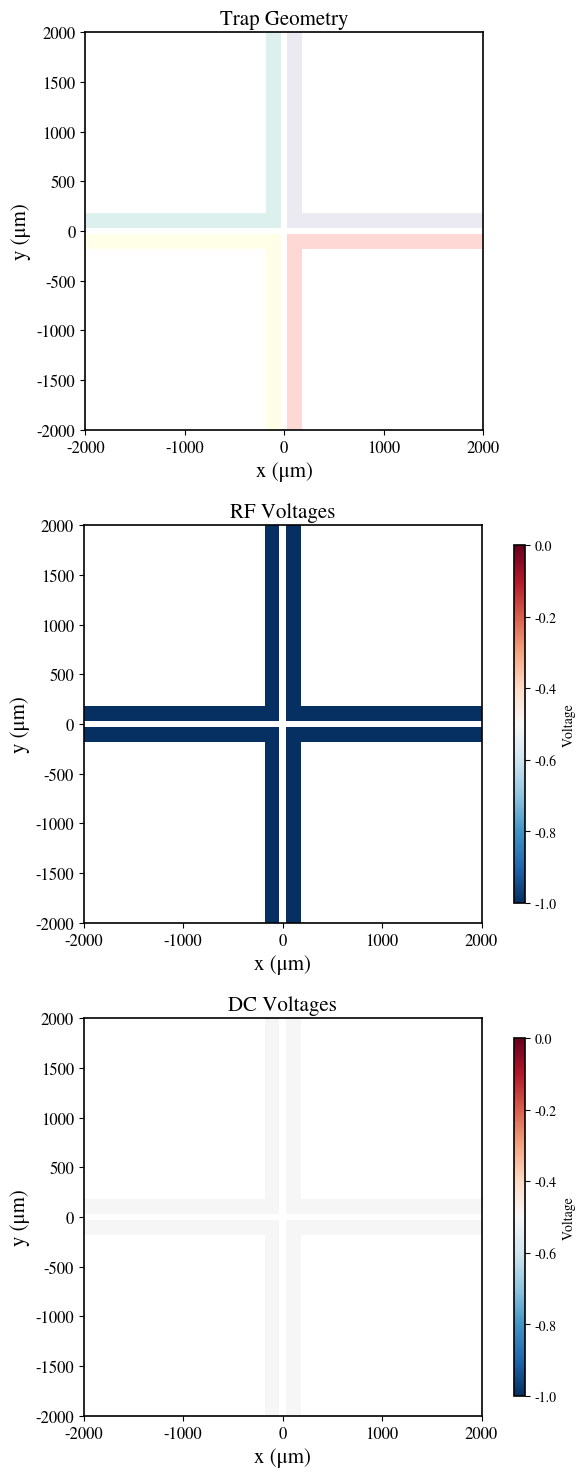

In [28]:
plot_trap_geometry(s, xmax=2000, ymax=2000)

In [29]:
# Define subsystems sorted into RF and DC electrodes
s_RF = System([entry for entry in s if not entry.dc])
s_DC = System([entry for entry in s if not entry.rf])

# Check which electrode is in which subsystem
print("RF-electrodes: {}".format(s_RF.names))
print("DC-electrodes: {}".format(s_DC.names))

RF-electrodes: ['RF_1', 'RF_2', 'RF_3', 'RF_4']
DC-electrodes: []


**Study of the pseudo-potential along x axis**

In [30]:
L = 1e-6 # μmlength scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)

V_RF = 42.2 # RF peak voltage
Omega = 2 * np.pi * 20e6 # RF frequency in rad/s

ps_factor = Q / (2 * Omega * np.sqrt(M))
pu_factor = V_RF / L

# RF voltage applied to the electrodes parametrized so that the resulting potential equals the RF pseudo-potential in eV
U_RF = pu_factor * ps_factor / np.sqrt(Q)

# Set all voltages to 0
for electrode in s:
    electrode.dc = 0
    electrode.rf = 0

# Turn on only RF voltages -> we set them equal to the chosen value of energy
for electrode in s_RF:
    electrode.rf = U_RF
    
print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))
print("Parametrized RF voltage: {} V".format(U_RF))

print("-------------------")

print("DC electrodes and their voltages:")

for e in s_DC:
    print("{}: {}".format(e.name, e.dc))
    
print("-------------------")

print("RF electrodes and their voltages:")

for e in s_RF:
    print("{}: {}".format(e.name, e.rf))
    
print("-------------------")

try:
    x0 = s.minimum(x0=(-2000., 10., 100.), axis=(1,2), coord=np.identity(3))
    print(f'Z position of the minimum far from the center = {x0[2]:.3f}')
    x0 = s.minimum(x0=(-5., 10., 100.), axis=(1,2), coord=np.identity(3))
    print(f'Z position of the minimum near the center = {x0[2]:.3f}')
except:
    print("minimum not found")

RF drive frequency: 20 MHz
RF voltage: 42.2 V
Parametrized RF voltage: 260.77937698627807 V
-------------------
DC electrodes and their voltages:
-------------------
RF electrodes and their voltages:
RF_1: 260.77937698627807
RF_2: 260.77937698627807
RF_3: 260.77937698627807
RF_4: 260.77937698627807
-------------------
Z position of the minimum far from the center = 74.962
Z position of the minimum near the center = 129.416


In [31]:
# Compute secular frequencies
try:
    x0 = s.minimum(x0=(-1500, x0[1], x0[2]), axis=(1,2), coord=np.identity(3))
    curve_z = s.modes(x0)
    omega_sec = np.sqrt(abs(curve_z[0]) * Q / M) / L
    mode_directions = np.transpose(curve_z[1])
    print("Secular frequencies: ({0:.4g}, {1:.4g}, {2:.4g}) MHz"
          .format(omega_sec[0]/(2*np.pi)/1e6, 
                  omega_sec[1]/(2*np.pi)/1e6, 
                  omega_sec[2]/(2*np.pi)/1e6))
    print("in directions {0[0]}, {0[1]}, {0[2]}".format(mode_directions))
except:
    print("secular frequencies not found")

Secular frequencies: (0.000978, 5.072, 5.073) MHz
in directions [ 1.0000e+00 -6.9067e-09  1.0404e-03], [-2.0228e-05 -9.9981e-01  1.9436e-02], [ 0.001  -0.0194 -0.9998]


In [32]:
max_q = (max(omega_sec))/Omega*np.sqrt(8)
print("max q-parameter {0:.3g}, max q-param per Volt {1:.3g}".format(max_q, max_q/V_RF))
print("--> apply {0:.3g}V for max q=0.4".format(0.4/max_q*V_RF))

max q-parameter 0.717, max q-param per Volt 0.017
--> apply 23.5V for max q=0.4


In [17]:
(ps_factor*pu_factor)**2/Q

68005.88346135133

In [18]:
x_values = np.linspace(-1000, 1, 2000)
x0 = (x_values[0], 10., 10.)

pseudopot_values = []
grad_values = []
E_values = []
positions = []
omega_sec_values = []
grad_values_2 = []
mode_directions = []

for x in x_values:
    try:
        x0 = s.minimum(x0=(x, x0[1], x0[2]), axis=(1,2), coord=np.identity(3))
        pseudopot_values.append(s.potential(x0, 0)[0])
        E_values.append(-s.potential(x0, 1)[0])
        positions.append(x0)
        curve_z = s.modes(x0)
        mode_directions.append(np.transpose(curve_z[1]))
        omega_sec_values.append(np.sqrt(abs(curve_z[0]) * Q / M) / L)

        E = -s.electrical_potential(x=x0, typ="rf", derivative=1)[0]
        grad_E = -s.electrical_potential(x=x0, typ="rf", derivative=2, expand=True)[0]
        
        grad_values_2.append(2 * np.einsum("i,ij->j", E, grad_E))

    except:
        print("minimum not found")
        pseudopot_values.append(s.potential(x0, 0)[0]* ps_factor**2)
        positions.append(x0)


grad_values = np.gradient(pseudopot_values, x_values)

In [19]:
# Define a threshold
threshold = 0.1

# Get indices of values near 0
indices_near_zero = np.where(np.abs(np.array(mode_directions)[:, 2, 1]) > threshold)[0]

# Swap secular frequencies
omega_sec_values = np.array(omega_sec_values)
copy_values = omega_sec_values[indices_near_zero, 1]
omega_sec_values[indices_near_zero, 1] = omega_sec_values[indices_near_zero, 2]
omega_sec_values[indices_near_zero, 2] = copy_values

In [22]:
def plot_ps(x_values, pseudopot_values, grad_values, positions, omega_sec):
    # Convert inputs to numpy arrays for safety
    x_values = np.array(x_values)
    pseudopot_values = np.array(pseudopot_values)/1e-3
    grad_values = np.array(grad_values)/1e-3
    positions = np.array(positions)
    omega_sec = np.array(omega_sec)

    # Define a scientific formatter
    sci_formatter = ScalarFormatter(useMathText=True)
    sci_formatter.set_powerlimits((-3, 3))

    # === Combined figure with three subplots ===
    fig1, (ax1, ax2, ax3) = plt.subplots(
        3, 1,                # 2 rows, 1 column
        figsize=(6, 6),      # adjust as needed
        sharex=True           # share x-axis
    )

    # === Top subplot: Pseudo-potential ===
    ax1.plot(
        x_values,
        pseudopot_values,
        color="#003366",    # dark blue
        label="Pseudo-potential"
    )
    ax1.set_ylabel(r"$\Phi_{PS} \ [\mathrm{meV}]$", labelpad=20)
    ax1.grid(True)
    # ax1.legend(loc='upper left')
    ax1.yaxis.set_major_formatter(sci_formatter)

    # === Mid subplot: Gradient ===
    ax2.plot(
        x_values,
        grad_values,
        color="#8B0000",    # deep red
        label=r"$\nabla_x \Phi_{PS}$"
    )
    ax2.set_ylabel(r"$\nabla_x \Phi_{PS} \ [\mathrm{meV} / \mathrm{\mu m}]$")
    ax2.grid(True)
    # ax2.legend(loc='upper left')
    ax2.xaxis.set_major_formatter(sci_formatter)
    ax2.yaxis.set_major_formatter(sci_formatter)

    # === Bottom subplot: Position of the minimum ===
    # ax3.plot(x_values, positions[:, 0], label='X Position')
    # ax3.plot(x_values, positions[:, 1], label='Y Position')

    # Z minimum in dark green
    ax3.plot(
        x_values,
        positions[:, 2],
        color="#006400",    # dark green
        label="Z minimum"
    )

    # Reference line at y = 100 μm in gray dashed
    ax3.plot(
        x_values,
        [100]*len(x_values),
        color="black",
        linestyle="--",
        linewidth=1.2,
        alpha=0.8,
        label=r"$y = 100\,\mathrm{\mu m}$"
    )

    ax3.set_xlabel(r"$x \ [\mathrm{\mu m}]$")
    ax3.set_ylabel(r"$h \ [\mathrm{\mu m}]$", labelpad=13)
    # ax3.legend(loc='upper left')
    ax3.grid(True)
    ax3.xaxis.set_major_formatter(sci_formatter)
    ax3.yaxis.set_major_formatter(sci_formatter)

    # Define the start of the shaded region
    x_shade_start = -41.5
    x_shade_end = 0  # or any other maximum

    # Add the shaded region to all three subplots
    for ax in [ax1, ax2, ax3]:
        ax.axvspan(
            x_shade_start,
            x_shade_end,
            color="#EEE8AC",
            alpha=0.5  # transparency
        )
        ax.axvspan(
            x_shade_start - 199,
            x_shade_start,
            color="#FBC901",
            alpha=0.5
        )


    plt.tight_layout()
    plt.show()

    # === Figure 2: Radial secular frequencies ===
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    # var_radial_1 = np.var(omega_sec[:, 1] / (2 * np.pi) / 1e6)
    # var_radial_2 = np.var(omega_sec[:, 2] / (2 * np.pi) / 1e6)
    ax2.plot(x_values, omega_sec[:, 0] / (2 * np.pi) / 1e6,
             label=r"$\omega_x$ (axial)", color='#003366')
    ax2.plot(x_values, omega_sec[:, 1] / (2 * np.pi) / 1e6,
             label=r"$\omega_y$ (radial)", color='#006400')
    ax2.plot(x_values, omega_sec[:, 2] / (2 * np.pi) / 1e6,
             label=r"$\omega_z$ (radial)", color='#8B0000')
    ax2.set_ylabel(r"Frequency $\ \ [\mathrm{MHz}]$")
    ax2.set_xlabel(r"$x \ \ [\mathrm{\mu m}]$")
    ax2.legend(loc='best')
    ax2.grid(True)
    ax2.xaxis.set_major_formatter(sci_formatter)
    ax2.yaxis.set_major_formatter(sci_formatter)
    
    ax2.axvspan(
            x_shade_start,
            x_shade_end,
            color="#EEE8AC",
            alpha=0.5  # transparency
        )
    ax2.axvspan(
            x_shade_start - 199,
            x_shade_start,
            color="#FBC901",
            alpha=0.5
        )
    
    plt.tight_layout()
    plt.show()

    return fig1, fig2

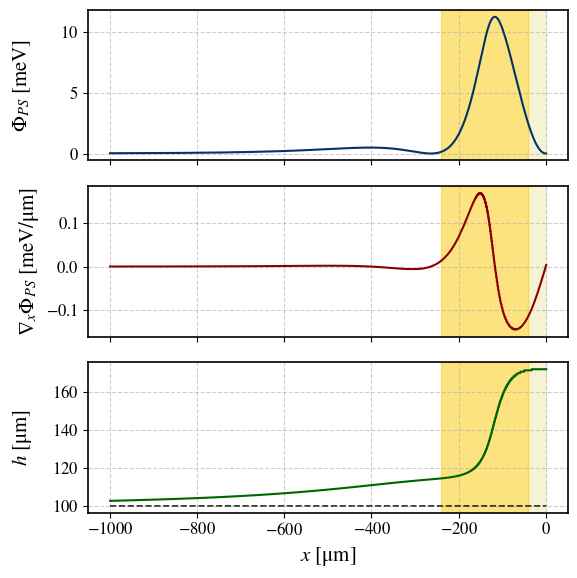

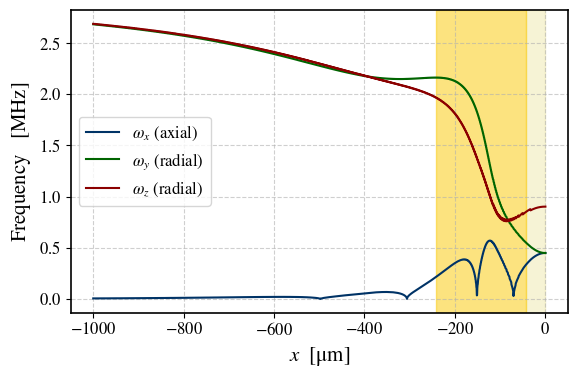

In [23]:
fig1, fig2 = plot_ps(x_values, pseudopot_values, np.array(grad_values_2)[:, 0], positions, omega_sec_values)
fig1.savefig("/home/kallo27/thesis/thesis_images/nonopt_junction_ps.pdf", bbox_inches="tight")
fig2.savefig("/home/kallo27/thesis/thesis_images/nonopt_junction_sec_freq.pdf", bbox_inches="tight")

In [1]:
import numpy as np
import gdspy
import scipy.constants as ct
import matplotlib.pyplot as plt

from electrode import System, PolygonPixelElectrode

# Load the GDS file
lib = gdspy.GdsLibrary(infile='/home/kallo27/thesis/gds_files/junction/non_optimized/junction_single_100um.gds')
                       
polys = []

# Get all cells
for cell_name, cell in lib.cells.items():
    polys = cell.polygons
    labels = cell.labels
                 
trap_polys = [poly.polygons for poly in polys if poly.layers[0] == 0]

system = System([PolygonPixelElectrode(name=n.text, paths=map(np.array, p)) for n, p in zip(labels, trap_polys)])

In [91]:
from matplotlib import rcParams

def plot_trap(system, yellow_indices=[25,26,27,28],
              blue_indices=[0,1,2,3], red_indices=None):
    
    if red_indices is None:
        red_indices = [i for i in range(len(system)) if i not in yellow_indices + blue_indices]
    
    def get_color(i):
        if i in blue_indices:
            return "#348ABD"
        elif i in yellow_indices:
            return "#CCCCCC"
        elif i in red_indices:
            return "#E24A33"
        else:
            return "#CCCCCC"

    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()
    
    for i, e in enumerate(system):
        for arr in e.paths:
            arr = np.array(arr)
            if not np.all(arr[0] == arr[-1]):
                arr = np.vstack([arr, arr[0]])  # close path
            plt.fill(arr[:,0], arr[:,1], color=get_color(i), edgecolor='k', linewidth=0.5)

        # Compute polygon centroid for label
        poly = np.array(e.paths[0])
        if not np.all(poly[0] == poly[-1]):
            poly = np.vstack([poly, poly[0]])
        x = poly[:,0]
        y = poly[:,1]
        A = 0.5*np.sum(x[:-1]*y[1:] - x[1:]*y[:-1])
        Cx = np.sum((x[:-1]+x[1:])*(x[:-1]*y[1:] - x[1:]*y[:-1]))/(6*A)
        Cy = np.sum((y[:-1]+y[1:])*(x[:-1]*y[1:] - x[1:]*y[:-1]))/(6*A)

        if i < len(system) - 4:
            ax.text(Cx, Cy, e.name, fontsize=10, fontfamily='STIXGeneral', ha='center', va='center', color='black')

    # Draw the red empty box
    box_coords = np.array([
        [-660, -90],
        [660, -90],
        [660, 90],
        [-660, 90],
        [-660, -90]  # close the box
    ])
    # Draw a thin filled box
    plt.fill(box_coords[:,0], box_coords[:,1], color='#FBC15E', alpha=0.5, edgecolor='black', linewidth=1.5)

    ax.set_aspect('equal', 'box')
    plt.axis('off')
    plt.show()
    
    return fig


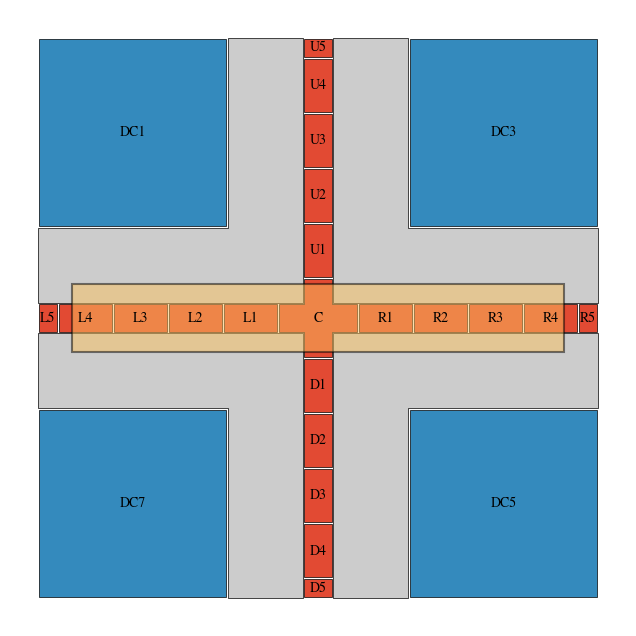

In [92]:
fig = plot_trap(system)
fig.savefig("/home/kallo27/thesis/thesis_images/nonopt_junction_dcs.pdf", bbox_inches="tight")